# Flax: From Zero to Hero!

## Enter Flax - the basics ❤️

In [ ]:
!pip install flax==0.12.0
!pip install jax==0.7.2
!pip install orbax==0.1.9

In [192]:
import jax
import jax.numpy as jnp

import flax
import flax.nnx as nnx

from flax import linen as nn  # nn notation also used in PyTorch and in Flax's older API
from flax.core import freeze, unfreeze
from flax.training import train_state # a useful dataclass to keep train state

import optax  # JAX optimizer

import orbax  # checkpointing and persistence utilities for JAX users.

# Flax doesn't have its own data loading functions - we'll be using PyTorch dataloaders
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import functools
from typing import Any, Callable, Sequence, Optional

import numpy as np
import matplotlib.pyplot as plt

### Some important notes about `seed`

`jax.random.split()` is the gold standard for reproducible ML experiments in JAX since it **mathematically guarantees** statistical independence. It is not only normal but the standard, recommended practice to initialize everything—model parameters, dataset generation, and initialization of specific components—from a single master seed using `jax.random.split()`

In [ ]:
# One master seed controls ALL randomness
seed = 42
key = jax.random.PRNGKey(seed)

# Split into independent streams
key, w_key, b_key = jax.random.split(key, num=3)
key, x_key, noise_key = jax.random.split(key, num=3)

Benefits:

- **Complete reproducibility**: Change seed once → entire experiment is reproducible
- **Independent randomness**: Each split key generates statistically independent random numbers
- **No accidental correlations**: Can't accidentally reuse the same random numbers

```python
# ❌ WRONG: Multiple independent seeds
w_key = random.PRNGKey(42)
b_key = random.PRNGKey(43)
x_key = random.PRNGKey(44)
noise_key = random.PRNGKey(45)

# Problems:
# - Hard to manage (4 different seeds to track)
# - Potential correlations if seeds are related
# - Can't easily reproduce entire experiment
```

### Best Practices for Key Management

In [49]:
# 1. Organize Keys by Purpose
def setup_experiment(seed: int):
    """Centralized key management for reproducible experiments"""

    # Master key
    master_key = jax.random.PRNGKey(seed)

    # Split into major categories
    master_key, model_key, data_key, training_key = jax.random.split(master_key, 4)

    # Model initialization keys
    model_key, w_key, b_key = jax.random.split(model_key, 3)

    # Data generation keys
    data_key, x_key, noise_key = jax.random.split(data_key, 3)

    # Training keys (for dropout, augmentation, etc.)
    training_key, dropout_key, augment_key = jax.random.split(training_key, 3)

    return {
        'model': {'w_key': w_key, 'b_key': b_key},
        'data': {'x_key': x_key, 'noise_key': noise_key},
        'training': {'dropout_key': dropout_key, 'augment_key': augment_key}
    }

# Usage
n_samples = 150
x_dim = 2
y_dim = 1

keys = setup_experiment(seed=42)
W = jax.random.normal(keys['model']['w_key'], (x_dim, y_dim))
xs = jax.random.normal(keys['data']['x_key'], (n_samples, x_dim))

In [50]:
# 2. Key Evolution Pattern
def generate_data_and_model(seed: int):
    """Proper key evolution - always split, never reuse"""

    key = jax.random.PRNGKey(seed)

    # Model parameters
    key, subkey = jax.random.split(key)  # Evolve main key
    W = jax.random.normal(subkey, (x_dim, y_dim))

    key, subkey = jax.random.split(key)  # Evolve again
    b = jax.random.normal(subkey, (y_dim,))

    # Data generation
    key, subkey = jax.random.split(key)
    xs = jax.random.normal(subkey, (n_samples, x_dim))

    key, subkey = jax.random.split(key)
    noise = jax.random.normal(subkey, (n_samples, y_dim))

    return W, b, xs, noise, key  # Return evolved key for future use

W, b, xs, noise, next_key = generate_data_and_model(42)
# This method of sequentially splitting the key (key = random.split(key, num=3)[0])
# is the standard pattern for ensuring every random call in your codebase is explicitly
# derived from the single initial seed. It is the correct way to guarantee reproducibility in JAX.

### Key Takeaway on Sequencing
The key idea is that you are not simply re-using the same random numbers; you are using the output of the previous split as the input for the next split. This ensures that the entire chain of random number generation is derived deterministically from the single initial seed.

1. **Single seed + splitting** is the gold standard

2. **Always evolve the key**: Use key, subkey = random.split(key) pattern

3. **Split by purpose**: Group related operations and split keys logically

4. **Document your splits**: Comment what each key is used for

5. **Never reuse keys**: Each random operation should get its own unique key

6. **Test reproducibility**: Same seed should give identical results every time

### NN in Flax
The goal of this notebook is to get you started with Flax!

I'll only cover the most essential parts of Flax (and Optax) - just as much as needed to get you started with training NNs!

In [33]:
# Let's start with the simplest model possible: a single feed-forward layer (linear regression)
layer = nn.Dense(features=5)

# All of the Flax NN layers inherit from the Module class (similarly to PyTorch)
print(nn.Dense.__base__)

<class 'flax.linen.module.Module'>


In [37]:
# Step 1: init
seed = 42
key_1, key_2 = jax.random.split(jax.random.PRNGKey(seed))
x = jax.random.normal(key=key_1, shape=(10,))  # create a dummy input, a 10-dimensional random vector

# Initialization call - this gives us the actual model weights
# (remember JAX handles state externally!)
# Initializes a module method with variables and returns output and modified variables.
# Returns: (output, vars), where vars are is a dict of the modified collections.
y, params = layer.init_with_output(key_2, x)
print(y)
print(jax.tree.map(lambda x: x.shape, params))

# Note1: automatic shape inference
# Note2: immutable structure (hence FrozenDict)
# Note3: init_with_output if you care, for whatever reason, about the output here

[ 1.3877232  -1.0392785   0.5252573  -0.49570093 -0.10908663]
{'params': {'bias': (5,), 'kernel': (10, 5)}}


In [38]:
# Step 2: apply
y = layer.apply(params, x)  # this is how you run prediction in Flax, state is external!
print(y)

[ 1.3877232  -1.0392785   0.5252573  -0.49570093 -0.10908663]


In [40]:
try:
    y = layer(x)  # this doesn't work anymore (bye bye PyTorch syntax)
except Exception as e:
    print(e)

Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.CallCompactUnboundModuleError)


### A toy example 🚚 - training a linear regression model
We'll first implement a pure-JAX appoach and then we'll do it the Flax-way.

In [55]:
n_samples = 150
x_dim = 2
y_dim = 1
noise_amplitude = 0.1

# Generate (random) ground truth W and b
# Note: we could get W, b from a randomely initialized nn.Dense here, being closer to JAX for now
key = jax.random.PRNGKey(seed)
key, w_key, b_key = jax.random.split(key=key, num=3)
W = jax.random.normal(key=w_key, shape=(x_dim, y_dim))
b = jax.random.normal(key=b_key, shape=(y_dim,))

# This is the structure that Flax expects (recall from the previous section!)
true_params = freeze({"params": {"bias": b, "kernel": W}})
xs = jax.random.normal(x_key, (n_samples, x_dim))
ys = jnp.dot(xs, W) + b
ys += noise_amplitude * jax.random.normal(noise_key, (n_samples, y_dim))
print(f'xs shape = {xs.shape} ; ys shape = {ys.shape}')

xs shape = (150, 2) ; ys shape = (150, 1)


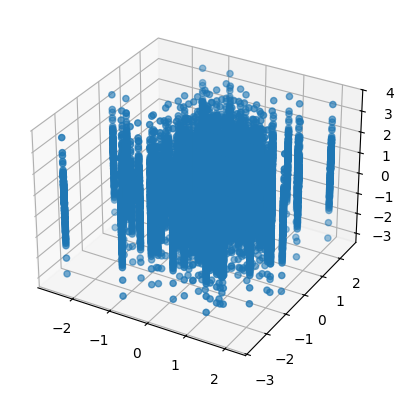

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
assert xs.shape[-1] == 2 and ys.shape[-1] == 1  # low dimensional data so that we can plot it
ax.scatter(xs[:, 0], xs[:, 1], zs=ys)

In [66]:
def make_mse_loss(xs, ys):
    def mse_loss(params):
        def squared_error(x, y):
            predictions = model.apply(params, x)
            # Inner because 'y' could have in general more than 1 dims
            return jnp.inner(y - predictions, y - predictions) / 2.0

        return jnp.mean(jax.vmap(squared_error)(xs, ys), axis=0)

    return jax.jit(mse_loss)

mse_loss = make_mse_loss(xs, ys)
value_and_grad_fn = jax.value_and_grad(mse_loss)

In [67]:
# Let's reuse the simple feed-forward layer since it trivially implements linear regression
model = nn.Dense(features=y_dim)
params = model.init(key, xs)
print(f"Initial params: {params}")

lr = 0.3
epochs = 20
log_period_epoch = 5

print("-" * 50)
for epoch in range(epochs):
    loss, grad = value_and_grad_fn(params)
    # SGD (closer to JAX again, but we'll progressively go towards how stuff is done in Flax)
    params = jax.tree.map(lambda p, g: p - lr * g, params, grad)

    if epoch % log_period_epoch == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss}")

print("-" * 50)
print(f'Learned params = {params}')
print(f'Gt params = {true_params}')

Initial params: {'params': {'kernel': Array([[ 0.02962372],
       [-0.47018084]], dtype=float32), 'bias': Array([0.], dtype=float32)}}
--------------------------------------------------
Epoch 1, Loss: 1.1732608079910278
Epoch 6, Loss: 0.027701344341039658
Epoch 11, Loss: 0.005299992859363556
Epoch 16, Loss: 0.004786742851138115
--------------------------------------------------
Learned params = {'params': {'bias': Array([0.42961958], dtype=float32), 'kernel': Array([[0.60322803],
       [0.8068402 ]], dtype=float32)}}
Gt params = FrozenDict({
    params: {
        bias: Array([0.4323065], dtype=float32),
        kernel: Array([[0.60576403],
               [0.7990441 ]], dtype=float32),
    },
})


In [70]:
preds = model.apply(params, xs)

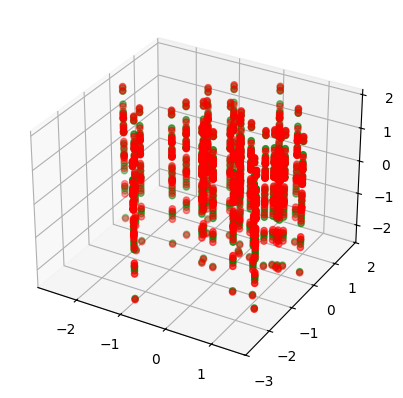

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
assert xs.shape[-1] == 2 and ys.shape[-1] == 1  # low dimensional data so that we can plot it
ax.scatter(xs[:30, 0], xs[:30, 1], zs=preds[:30], c="r")
ax.scatter(xs[:30, 0], xs[:30, 1], zs=ys[:30], c="g")

Now let's do the same thing but this time with dedicated optimizers!

Enter DeepMind's optax! ❤️🔥

In [77]:
opt_sgd = optax.sgd(learning_rate=lr)
opt_state = opt_sgd.init(params)  # always the same pattern - handling state externally
print(opt_state)


(EmptyState(), EmptyState())


In [78]:
params = model.init(key, xs)

for epoch in range(epochs):
    loss, grad = value_and_grad_fn(params)
    updates, opt_state = opt_sgd.update(updates=grad, state=opt_state) # arbitrary optim logic!
    params = optax.apply_updates(params=params, updates=updates)

    if (epoch % log_period_epoch == 0):
        print(f"Epoch {epoch + 1}, Loss: {loss}")

# Note 1: as expected we get the same loss values
# Note 2: we'll later see more concise ways to handle all of these state components (hint: TrainState)

Epoch 1, Loss: 1.1732608079910278
Epoch 6, Loss: 0.027701344341039658
Epoch 11, Loss: 0.005299992859363556
Epoch 16, Loss: 0.004786742851138115


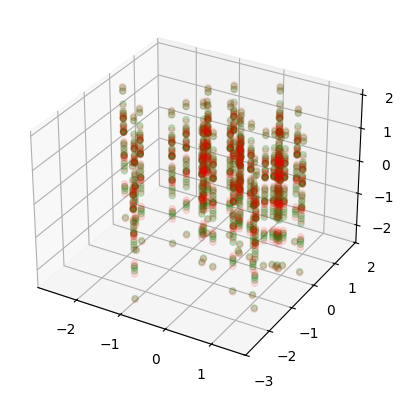

In [82]:
preds = model.apply(params, xs)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
assert xs.shape[-1] == 2 and ys.shape[-1] == 1  # low dimensional data so that we can plot it
ax.scatter(xs[:30, 0], xs[:30, 1], zs=preds[:30], c="r", alpha=0.1)
ax.scatter(xs[:30, 0], xs[:30, 1], zs=ys[:30], c="g", alpha=0.2)

```python
# Example from Flax (ImageNet example)
# https://github.com/google/flax/blob/main/examples/imagenet/train.py#L90
def create_learning_rate_fn(
    config: ml_collections.ConfigDict,
    base_learning_rate: float,
    steps_per_epoch: int,
):
  """Create learning rate schedule."""
    warmup_fn = optax.linear_schedule(
        init_value=0.0,
        end_value=base_learning_rate,
        transition_steps=config.warmup_epochs * steps_per_epoch,
    )
    cosine_epochs = max(config.num_epochs - config.warmup_epochs, 1)
    cosine_fn = optax.cosine_decay_schedule(
        init_value=base_learning_rate, decay_steps=cosine_epochs * steps_per_epoch
    )
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[config.warmup_epochs * steps_per_epoch],
    )
    return schedule_fn

tx = optax.sgd(
      learning_rate=learning_rate_fn,
      momentum=config.momentum,
      nesterov=True,
)

# Example from Haiku (ImageNet example)
# https://github.com/deepmind/dm-haiku/blob/main/examples/imagenet/train.py#L117
def make_optimizer() -> optax.GradientTransformation:
    """SGD with nesterov momentum and a custom lr schedule."""
    return optax.chain(
        optax.trace(
            decay=FLAGS.optimizer_momentum,
            nesterov=FLAGS.optimizer_use_nesterov),
        optax.scale_by_schedule(lr_schedule), optax.scale(-1))
```

Now let's go beyond these extremely simple models!

### Creating custom models with Flax linen ⭐

In [86]:
#  A flax.linen.Module (nn.Module) instance is stateless - the variables are returned from a purely functional Module.init()
class MLP(nn.Module):
    num_neurons_per_layer: Sequence[int]

    def setup(self):  # because dataclass is implicitly using the  __init__ function... :')
        self.layers = [nn.Dense(n) for n in self.num_neurons_per_layer]

    def __call__(self, x):
        activation = x
        for i, layer in enumerate(self.layers):
            activation = layer(activation)
            if i != len(self.layers) - 1:
                activation = nn.relu(activation)
        return activation

seed = 42
key = jax.random.PRNGKey(seed)
x_key, init_key = jax.random.split(key=key)

model = MLP(num_neurons_per_layer=[16, 8, 1])  # define an MLP model
x = jax.random.uniform(key=x_key, shape=(4, 4))  # dummy input
params = model.init(init_key, x)  # initialize via init
y = model.apply(params, x)  # do a forward pass via apply

print(jax.tree.map(jnp.shape, params))
print(f"Output: {y}")

{'params': {'layers_0': {'bias': (16,), 'kernel': (4, 16)}, 'layers_1': {'bias': (8,), 'kernel': (16, 8)}, 'layers_2': {'bias': (1,), 'kernel': (8, 1)}}}
Output: [[0.06860371]
 [0.12302881]
 [0.07388676]
 [0.20193087]]


1. **Stateless Modules** explanation
```python
# The module itself has NO parameters:
model = MLP(num_neurons_per_layer=[16, 8, 1])
print(type(model))  # <class '__main__.MLP'>
# model is just a "blueprint" - no weights stored here!
```
2. **Separate Parameter Initialization**
```python
# Parameters are created separately via init():
params = model.init(init_key, x)  # Returns a nested dict of parameters

# Structure: {'params': {'layers_0': {'kernel': ..., 'bias': ...}, ...}}
print(jax.tree.map(jnp.shape, params))
```
3. **Forward Pass via apply()**
```python
# Forward pass requires both model AND parameters:
y = model.apply(params, x)  # Pure function: (params, input) → output

# This is a PURE FUNCTION - same params + input = same output
# No hidden state, fully reproducible
```

`setup()`: This method is called internally during initialization (model.init). It registers submodules (nn.Dense) but does not execute the parameter initialization itself.

In [88]:
# Alternative using @nn.compact:
class MLP(nn.Module):
    num_neurons_per_layer: Sequence[int]

    @nn.compact  # Allows inline layer definition
    def __call__(self, x):
        activation = x
        for i, n_neurons in enumerate(self.num_neurons_per_layer):
            activation = nn.Dense(n_neurons)(activation)  # Define layers inline without using `setup()`
            if i != len(self.num_neurons_per_layer) - 1:
                activation = nn.relu(activation)
        return activation

seed = 42
key = jax.random.PRNGKey(seed)
x_key, init_key = jax.random.split(key=key)

model = MLP(num_neurons_per_layer=[16, 8, 1])  # define an MLP model
x = jax.random.uniform(key=x_key, shape=(4, 4))  # dummy input
params = model.init(init_key, x)  # initialize via init
y = model.apply(params, x)  # do a forward pass via apply

print(jax.tree.map(jnp.shape, params))
print(f"Output: {y}")
# Naming of the parameters are different due to different initialization of the model

{'params': {'Dense_0': {'bias': (16,), 'kernel': (4, 16)}, 'Dense_1': {'bias': (8,), 'kernel': (16, 8)}, 'Dense_2': {'bias': (1,), 'kernel': (8, 1)}}}
Output: [[-0.23753011]
 [-0.10775982]
 [-0.0412451 ]
 [-0.12891299]]


Great!

Now that we know how to build more complex models let's dive deeper and understand how the 'nn.Dense' module is designed itself.

### Introducing "param"

In [91]:
class MyDenseImp(nn.Module):
    num_neurons: int
    weight_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        weight = self.param(
            "weight",   # parametar name (as it will appear in the FrozenDict)
            self.weight_init,  # initialization function, RNG passed implicitly through init fn
            (x.shape[-1], self.num_neurons)  # shape info
        )
        bias = self.param(
            "bias",   # parametar name (as it will appear in the FrozenDict)
            self.bias_init,  # initialization function, RNG passed implicitly through init fn
            (self.num_neurons,)  # shape info
        )
        return jnp.dot(x, weight) + bias
seed = 42
key = jax.random.PRNGKey(seed)
x_key, init_key = jax.random.split(key)
x = jax.random.uniform(x_key, (4, 4))  # dummy input
model = MyDenseImp(num_neurons=3)  # initialize the model
params = model.init(init_key, x)  # initialize via init
y = model.apply(params, x)  # do a forward pass via apply

print(jax.tree.map(jnp.shape, params))
print(f"Output: {y}")

{'params': {'bias': (3,), 'weight': (4, 3)}}
Output: [[-0.6554082   0.39954066 -0.27109465]
 [-0.69957155 -0.13668317 -0.6816966 ]
 [-0.8172815  -0.10496789 -0.4252412 ]
 [-0.8836723  -0.22822976 -0.7505394 ]]


In [92]:
from inspect import signature

# You can see it expects a PRNG key and it is passed implicitly through the init fn (same for zeros)
print(signature(nn.initializers.lecun_normal()))

(key: 'Array', shape: 'core.Shape', dtype: 'DTypeLikeInexact | None' = None, out_sharding: 'OutShardingType' = None) -> 'Array'


So far we've only seen trainable params.

ML models often times have variables which are part of the state but are not optimized via gradient descent.

Let's see how we can handle them using a simple (and contrived) example!

### Introducing "variable"

Note on terminology: variable is a broader term and it includes both params (trainable variables) as well as non-trainable vars.

In [98]:
class BiasAdderWithRunningMean(nn.Module):
    decay: float = 0.99

    @nn.compact
    def __call__(self, x):
        is_initialized = self.has_variable("batch_stats", "ema")

        # 'batch_stats' is not an arbitrary name!
        # Flax uses that name in its implementation of BatchNorm (hard-coded, probably not the best design)
        ema = self.variable("batch_stats", "ema", lambda shape: jnp.zeros(shape), x.shape[1:])

        # self.params will by default add this variable to 'params' collection (vs 'batch_stat' above)
        bias = self.param("bias", lambda key, shape: jnp.zeros(shape), x.shape[1:])

        if is_initialized:
            # self.variable returns a reference hence .value
            ema.value = self.decay * ema.value + (1.0 - self.decay) * jnp.mean(x, axis=0, keepdims=True)
        return x - ema.value + bias

seed = 42
key = jax.random.PRNGKey(seed)
x_key, init_key = jax.random.split(key)
x = jax.random.uniform(x_key, (10, 4))  # dummy input
model = BiasAdderWithRunningMean()
variables = model.init(init_key, x)
print(f"Multiple collections: {variables}")  # we can now see a new collection 'batch_stats'

# We have to use mutable since regular params are not modified during the forward
# pass, but these variables are. We can't keep state internally (because JAX) so we have to return it.
y, updated_non_trainable_params = model.apply(variables, x, mutable=["batch_stats"])
print(updated_non_trainable_params)

Multiple collections: {'batch_stats': {'ema': Array([0., 0., 0., 0.], dtype=float32)}, 'params': {'bias': Array([0., 0., 0., 0.], dtype=float32)}}
{'batch_stats': {'ema': Array([[0.0053374 , 0.00545211, 0.00495344, 0.00602593]], dtype=float32)}}


In [105]:
# Let's see how we could train such model!
def update_step(opt, apply_fn, x, opt_state, params, non_trainable_params):
    def loss_fn(params):
        y, updated_non_trainable_params = apply_fn(
            {"params": params, **non_trainable_params},
            x, mutable=list(non_trainable_params.keys())
        )

        loss = ((x - y)**2).sum()  # not doing anything really, just for the demo purpose

        return loss, updated_non_trainable_params

    (loss, updated_non_trainable_params), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params=params, updates=updates)

    return opt_state, params, updated_non_trainable_params

x = jnp.ones((10, 4))
model = BiasAdderWithRunningMean()
variables = model.init(init_key, x)
params = variables.pop('params')
non_trainable_params = variables
del variables  # delete variables to avoid wasting resources (this pattern is used in the official code)

sgd_opt = optax.sgd(learning_rate=0.1)  # originally you'll see them use the 'tx' naming (from opTaX)
opt_state = sgd_opt.init(params)

for _ in range(3):
    opt_state, params, non_trainable_params = update_step(sgd_opt, model.apply, x, opt_state, params, non_trainable_params)
    print(non_trainable_params)

{'batch_stats': {'ema': Array([[0.01, 0.01, 0.01, 0.01]], dtype=float32)}}
{'batch_stats': {'ema': Array([[0.0199, 0.0199, 0.0199, 0.0199]], dtype=float32)}}
{'batch_stats': {'ema': Array([[0.029701, 0.029701, 0.029701, 0.029701]], dtype=float32)}}


Let's go a level up in abstraction again now that we understand params and variables!

Certain layers like BatchNorm will use variables in the background.

Let's see a last example that is conceptually as complicated as it gets when it comes to Flax's idiosyncrasies, and high-level at the same time.

In [113]:
class DDNBlock(nn.Module):
    """Dense, dropout + batchnorm combo.

    Contains trainable variables (params), non-trainable variables (batch stats),
    and stochasticity in the forward pass (because of dropout).
    """
    num_neurons: int
    training: bool

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.num_neurons)(x)
        x = nn.Dropout(rate=0.5, deterministic=not self.training)(x)
        x = nn.BatchNorm(use_running_average=not self.training)(x)
        return x

seed = 42
key = jax.random.PRNGKey(seed)
data_key, params_key, dropout_init_key, dropout_apply_key = jax.random.split(key=key, num=4)
# two dropout keys:
# Init key: For the initialization forward pass (shape tracing)
# Apply key: For actual training/inference forward passes
# When training=False, Dropout is deterministic → no RNG key needed in apply()

model = DDNBlock(num_neurons=3, training=True)
x = jax.random.uniform(data_key, (3, 4, 4))

# New: because of Dropout we now have to include its unique key - kinda weird, but you get used to it
variables = model.init({"params": params_key, "dropout": dropout_init_key}, x)
print(f"Variable: {variables}")

# And same here, everything else remains the same as the previous example
y, non_trainable_params = model.apply(variables, x, rngs={"dropout": dropout_apply_key}, mutable=["batch_stats"])

# let's run these model variables during "evaluation":
eval_model = DDNBlock(num_neurons=3, training=False)
# Because training=False we don't have stochasticity in the forward pass neither do we update the stats
y = eval_model.apply(variables, x)

Variable: {'params': {'Dense_0': {'kernel': Array([[ 0.02047942,  0.42524156, -0.02647197],
       [ 0.9521522 ,  0.83275634, -0.54273474],
       [-0.4647561 , -0.29997867, -0.49021766],
       [ 0.57899   , -0.10725123,  0.19770078]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}, 'BatchNorm_0': {'scale': Array([1., 1., 1.], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}}, 'batch_stats': {'BatchNorm_0': {'mean': Array([0., 0., 0.], dtype=float32), 'var': Array([1., 1., 1.], dtype=float32)}}}


### A fully-fledged CNN on MNIST example in Flax! 💥

Modified the official MNIST example here: https://github.com/google/flax/tree/main/examples/mnist

We'll be using PyTorch dataloading instead of TFDS.

Let's start by defining a model:

In [129]:
class CNN(nn.Module):  # lots of hardcoding, but it serves a purpose for a simple demo
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten()
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

Let's add the data loading support in PyTorch!

I'll be reusing code from tutorial #3:

In [160]:
def custom_transform(x):
    return np.expand_dims(np.array(x, dtype=np.float32), axis=2) / 255.

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    images = np.array(transposed_data[0])

    return images, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
images = batch_data[0]
labels = batch_data[1]
print(images.shape, images[0].dtype, labels.shape, labels[0].dtype)

# optimization - laoding the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_labels = jnp.array(train_dataset.targets)

test_images = np.expand_dims(jnp.array(test_dataset.data), axis=3)
test_labels = jnp.array(test_dataset.targets)

(128, 28, 28, 1) float32 (128,) int64


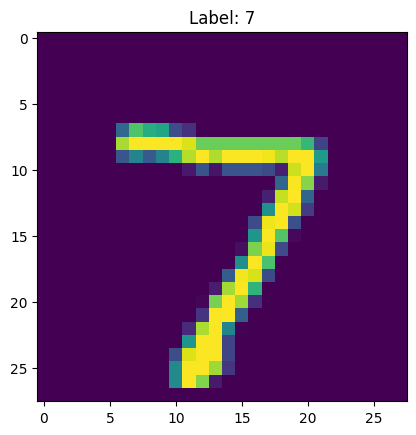

In [154]:
# Visualize a single image
images, labels = next(iter(test_loader))
image = images[0].reshape(mnist_img_size)[:, :, 0]
gt_label = labels[0]

plt.imshow(image)
plt.title(f"Label: {gt_label}")
plt.show()

Great - we have our data pipeline ready and the model architecture defined.

Now let's define core training functions:

In [193]:
@jax.jit
def train_step(state, images, gt_labels):
    def loss_fn(params):
        logits = state.apply_fn({"params": params}, images)
        one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, gt_labels).mean()
        return loss, logits

    (_, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)  # this is the whole update now! concise!
    metrics = compute_metrics(logits=logits, gt_labels=gt_labels)  # duplicating loss calculation but it's a bit cleaner
    return state, metrics

@jax.jit
def eval_step(state, images, labels):
    logits = state.apply_fn({"params": state.params}, images)
    return compute_metrics(logits=logits, gt_labels=labels)

In [194]:
def train_one_epoch(state, dataloader, epoch):
    batch_metrics = []
    for index, (images, labels) in enumerate(dataloader):
        state, metrics = train_step(state, images, labels)
        batch_metrics.append(metrics)

    # Aggregate the metrics
    batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }
    return state, epoch_metrics_np

def evaluate_model(state, test_images, test_labels):
    metrics = eval_step(state, test_images, test_labels)
    metrics = jax.device_get(metrics)  # pull from the accelerator onto host (CPU)
    metrics = jax.tree.map(lambda x: x.item(), metrics)  # np.ndarray -> scalar
    return metrics

In [195]:
def create_train_state(key, learning_rate, momentum):
    cnn = CNN()
    dummy_input = jnp.ones([1, *mnist_img_size])  # (batch, height, width, channels)
    params = cnn.init(key, dummy_input)["params"]
    sgd_opt = optax.sgd(learning_rate=learning_rate, momentum=momentum)
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=sgd_opt)

def compute_metrics(*, logits, gt_labels):
    """Compute cross-entropy loss and accuracy"""
    # Use proper cross-entropy loss with raw logits
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, gt_labels).mean()
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == gt_labels)

    return {
        "loss": loss,
        "accuracy": accuracy,
    }

In [196]:
seed = 0
learning_rate = 0.1
momentum = 0.9
num_epochs = 2
batch_size = 32

key = jax.random.PRNGKey(seed)
train_state = create_train_state(key, learning_rate, momentum)

for epoch in range(num_epochs):
    train_state, train_metrics = train_one_epoch(train_state, train_loader, momentum)
    print(f"Train epoch: {epoch}, loss: {train_metrics['loss']}, accuracy: {train_metrics['accuracy'] * 100}")

    test_metrics = evaluate_model(train_state, test_images, test_lbls)
    print(f"Test epoch: {epoch}, loss: {test_metrics['loss']}, accuracy: {test_metrics['accuracy'] * 100}")

Train epoch: 0, loss: 0.2164946347475052, accuracy: 93.77503967285156
Test epoch: 0, loss: 20.95661163330078, accuracy: 96.7199981212616
Train epoch: 1, loss: 0.04868984594941139, accuracy: 98.48424530029297
Test epoch: 1, loss: 17.979204177856445, accuracy: 97.3800003528595


In [198]:
logits = train_state.apply_fn({"params": train_state.params}, images)

In [201]:
pred_labels = jnp.argmax(logits, axis=-1)

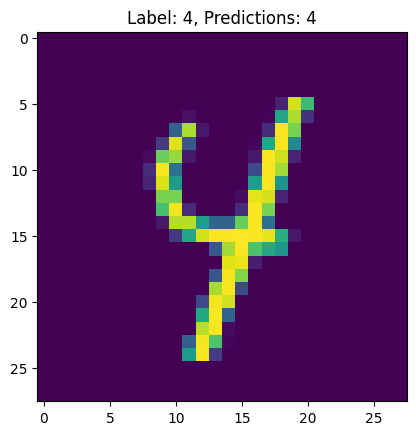

In [205]:
# Visualize a single image
index = 30
image = images[index].reshape(mnist_img_size)[:, :, 0]
gt_label = labels[index]

plt.imshow(image)
plt.title(f"Label: {gt_label}, Predictions: {pred_labels[index]}")
plt.show()